In [1]:
import time
import torch
import triton
import triton.language as tl

In [2]:
def softmax_naive_torch(x: torch.Tensor) -> torch.Tensor:
    x_max = x.max(dim=1, keepdim=True).values          # (N, 1)
    safe_x = x - x_max                                 # (N, M)
    exp_x = torch.exp(safe_x)                          # (N, M)
    denom = exp_x.sum(dim=1, keepdim=True)             # (N, 1)
    return exp_x / denom                               # (N, M)

In [3]:
def softmax_pytorch(x: torch.Tensor) -> torch.Tensor:
    return torch.softmax(x, dim=1)

In [4]:
@triton.jit
def _softmax(Y, stride_y_row, X, stride_x_row, M, N, BLOCK_SIZE : tl.constexpr):
    # program idx gives row idx
    row_idx = tl.program_id(0)

    input_row_ptr = X + (row_idx * stride_x_row)
    col_indices = tl.arange(0,BLOCK_SIZE)
    input_ptrs = input_row_ptr + col_indices

    mask = col_indices < N      # mask for valid inputs

    row = tl.load(input_ptrs, mask=mask, other=float("-inf"))

    row = row - tl.max(row, axis=0)
    row = tl.exp(row)
    denom = tl.sum(row, axis=0)
    row = row / denom

    output_row_ptr = Y + (row_idx * stride_y_row)
    output_ptrs = output_row_ptr + col_indices

    tl.store(output_ptrs, row, mask=mask)

def softmax_triton(X: torch.Tensor) -> torch.Tensor:
    # Allocate input/output tensors
    rows, cols = X.shape
    assert(X.dim()==2)

    BLOCK_SIZE = triton.next_power_of_2(cols)

    num_warps = 4
    if BLOCK_SIZE > 2047:
        num_warps = 8
    if BLOCK_SIZE > 4095:
        num_warps = 16

    Y = torch.empty_like(X)     # output buffer

    # SPMD launch grid
    grid = (rows, )
    # enqueue GPU kernel
    _softmax[grid](Y, Y.stride(0),
                X, X.stride(0),
                rows, cols, BLOCK_SIZE,
                num_warps=num_warps)

    return Y

In [5]:
# -----------------------------
# Timing helpers
# -----------------------------
@torch.no_grad()
def time_ms(fn, x, iters=100, warmup=25):
    # Warmup
    for _ in range(warmup):
        fn(x)
    torch.cuda.synchronize()

    start = torch.cuda.Event(enable_timing=True)
    end   = torch.cuda.Event(enable_timing=True)
    start.record()
    for _ in range(iters):
        fn(x)
    end.record()
    torch.cuda.synchronize()
    return start.elapsed_time(end) / iters

In [6]:
torch.manual_seed(0)
device = "cuda"

# Choose shapes that make IO matter:
# M large enough to keep SMs busy, N moderately large
M = 81920
N = 4096  # try 1024, 2048, 4096, 8192

x = torch.randn((M, N), device=device, dtype=torch.float16)

# Correctness check (compare to torch.softmax ONLY for validation, not timing)
ref = softmax_pytorch(x)
naive = softmax_naive_torch(x)
max_err = (naive - ref).abs().max().item()
print(f"max abs error naive vs torch.softmax: {max_err:.3e}")

y_triton = softmax_triton(x)
max_err = (y_triton - ref).abs().max().item()
print(f"max abs error triton vs torch.softmax: {max_err:.3e}")

# Benchmarks
t_naive  = time_ms(softmax_naive_torch, x)
t_pytorch = time_ms(softmax_pytorch, x)
t_triton = time_ms(softmax_triton, x)

print(f"naive torch composition: {t_naive:.3f} ms")
print(f"fused pytorch softmax:    {t_pytorch:.3f} ms")
print(f"fused triton softmax:    {t_triton:.3f} ms")
print(f"speedup pytorch native:                {t_naive / t_pytorch:.2f}x")
print(f"speedup triton:                {t_naive / t_triton:.2f}x")


max abs error naive vs torch.softmax: 3.052e-05
max abs error triton vs torch.softmax: 3.815e-06
naive torch composition: 4.487 ms
fused pytorch softmax:    1.810 ms
fused triton softmax:    0.771 ms
speedup pytorch native:                2.48x
speedup triton:                5.82x


## Benchmarking Sweeps

In [16]:
import math
import torch
import matplotlib.pyplot as plt

# -----------------------------
# assumes you already have:
#   time_ms(fn, x, iters=..., warmup=...)
#   softmax_naive_torch(x)
#   softmax_pytorch(x)
#   softmax_triton(x)
# -----------------------------

device = "cuda"
dtype  = torch.float16

def next_pow2(n: int) -> int:
    return 1 if n <= 1 else 1 << (n - 1).bit_length()

def num_warps_for_block(BLOCK_SIZE: int) -> int:
    # matches your logic
    nw = 4
    if BLOCK_SIZE > 2047:
        nw = 8
    if BLOCK_SIZE > 4095:
        nw = 16
    return nw

def bytes_per_elem(dtype: torch.dtype) -> int:
    return torch.tensor([], dtype=dtype).element_size()

def softmax_bytes_fused_lb(M: int, N: int, dtype: torch.dtype) -> int:
    # lower bound: read X once + write Y once
    b = bytes_per_elem(dtype)
    return M * N * (b + b)

def softmax_bytes_naive_proxy(M: int, N: int, dtype: torch.dtype, mult: float = 4.0) -> float:
    # crude proxy for extra intermediates in naive torch composition
    return mult * softmax_bytes_fused_lb(M, N, dtype)

def gbps(bytes_moved: float, ms: float) -> float:
    return bytes_moved / (ms * 1e-3) / 1e9

@torch.no_grad()
def benchmark_one_shape(
    M: int, N: int,
    *,
    iters_naive=80,
    iters_fused=200,
    warmup=25,
    prewarm_extra_triton=0,
    correctness=False,
    make_contiguous=True,
):
    x = torch.randn((M, N), device=device, dtype=dtype)
    if make_contiguous:
        x = x.contiguous()

    # optional correctness (cheap-ish, but do it sparingly in big sweeps)
    err_naive = None
    err_triton = None
    if correctness:
        ref = softmax_pytorch(x)
        y_n = softmax_naive_torch(x)
        y_t = softmax_triton(x)
        err_naive  = (y_n - ref).abs().max().item()
        err_triton = (y_t - ref).abs().max().item()

    # IMPORTANT: your triton kernel has no autotune, but first call compiles.
    # time_ms(warmup=...) covers that; extra prewarm is optional.
    for _ in range(prewarm_extra_triton):
        softmax_triton(x)
    torch.cuda.synchronize()

    t_naive  = time_ms(softmax_naive_torch, x, iters=iters_naive, warmup=warmup)
    t_torch  = time_ms(softmax_pytorch,     x, iters=iters_fused, warmup=warmup)
    t_triton = time_ms(softmax_triton,      x, iters=iters_fused, warmup=warmup)

    BS  = next_pow2(N)               # should match triton.next_power_of_2(cols)
    nw  = num_warps_for_block(BS)

    b_fused = softmax_bytes_fused_lb(M, N, dtype)
    b_naive = softmax_bytes_naive_proxy(M, N, dtype)

    return {
        "M": M, "N": N,
        "BLOCK_SIZE": BS, "num_warps": nw,
        "ms_naive": t_naive,
        "ms_torch": t_torch,
        "ms_triton": t_triton,
        "speedup_torch_over_naive": t_naive / t_torch,
        "speedup_triton_over_naive": t_naive / t_triton,
        "speedup_triton_over_torch": t_torch / t_triton,
        "GBps_torch_lb": gbps(b_fused, t_torch),
        "GBps_triton_lb": gbps(b_fused, t_triton),
        "GBps_naive_proxy": gbps(b_naive, t_naive),
        "max_err_naive": err_naive,
        "max_err_triton": err_triton,
    }

@torch.no_grad()
def sweep_softmax(
    Ms,
    Ns,
    *,
    iters_naive=80,
    iters_fused=200,
    warmup=25,
    correctness_every=0,     # 0 = never, else check every K configs
    keep_total_elems=None,  # e.g. keep_total_elems=81920*4096 to isolate shape effects
):
    results = []
    idx = 0
    for N in Ns:
        Ms_eff = Ms
        if keep_total_elems is not None:
            # keep M*N approx constant; round M up to multiple of 256
            M = max(1, keep_total_elems // N)
            M = int(math.ceil(M / 256) * 256)
            Ms_eff = [M]

        for M in Ms_eff:
            idx += 1
            do_corr = (correctness_every > 0) and (idx % correctness_every == 0)

            try:
                r = benchmark_one_shape(
                    M, N,
                    iters_naive=iters_naive,
                    iters_fused=iters_fused,
                    warmup=warmup,
                    correctness=do_corr,
                )
            except RuntimeError as e:
                print(f"[skip] M={M} N={N}: {e}")
                continue

            results.append(r)
            print(
                f"M={M:>7} N={N:>5} | BS={r['BLOCK_SIZE']:>5} nw={r['num_warps']:>2} | "
                f"naive {r['ms_naive']:7.3f} ms | torch {r['ms_torch']:7.3f} ms | triton {r['ms_triton']:7.3f} ms | "
                f"triton/torch {r['speedup_triton_over_torch']:5.2f}x"
            )
    return results

# -----------------------------
# plotting utilities (matplotlib, no custom colors)
# -----------------------------
def _filter(results, *, M=None, N=None):
    out = []
    for r in results:
        if M is not None and r["M"] != M: continue
        if N is not None and r["N"] != N: continue
        out.append(r)
    return out

def plot_time_vs_N(results, fixed_M: int, title_extra=""):
    rs = sorted(_filter(results, M=fixed_M), key=lambda r: r["N"])
    if not rs:
        print(f"No results for M={fixed_M}")
        return
    Ns = [r["N"] for r in rs]
    t_naive  = [r["ms_naive"] for r in rs]
    t_torch  = [r["ms_torch"] for r in rs]
    t_triton = [r["ms_triton"] for r in rs]

    plt.figure()
    plt.plot(Ns, t_naive,  marker="o", label="naive composition")
    plt.plot(Ns, t_torch,  marker="o", label="torch.softmax")
    plt.plot(Ns, t_triton, marker="o", label="triton fused")
    plt.xscale("log", base=2)
    plt.xlabel("N (cols)")
    plt.ylabel("time (ms)")
    plt.title(f"Softmax time vs N (M={fixed_M}) {title_extra}".strip())
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

def plot_time_vs_M(results, fixed_N: int, title_extra=""):
    rs = sorted(_filter(results, N=fixed_N), key=lambda r: r["M"])
    if not rs:
        print(f"No results for N={fixed_N}")
        return
    Ms = [r["M"] for r in rs]
    t_naive  = [r["ms_naive"] for r in rs]
    t_torch  = [r["ms_torch"] for r in rs]
    t_triton = [r["ms_triton"] for r in rs]

    plt.figure()
    plt.plot(Ms, t_naive,  marker="o", label="naive composition")
    plt.plot(Ms, t_torch,  marker="o", label="torch.softmax")
    plt.plot(Ms, t_triton, marker="o", label="triton fused")
    plt.xscale("log", base=2)
    plt.xlabel("M (rows)")
    plt.ylabel("time (ms)")
    plt.title(f"Softmax time vs M (N={fixed_N}) {title_extra}".strip())
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

def plot_speedups_vs_N(results, fixed_M: int, title_extra=""):
    rs = sorted(_filter(results, M=fixed_M), key=lambda r: r["N"])
    if not rs:
        print(f"No results for M={fixed_M}")
        return
    Ns = [r["N"] for r in rs]
    s_torch  = [r["speedup_torch_over_naive"] for r in rs]
    s_triton = [r["speedup_triton_over_naive"] for r in rs]
    s_tt     = [r["speedup_triton_over_torch"] for r in rs]

    plt.figure()
    plt.plot(Ns, s_torch,  marker="o", label="torch over naive")
    plt.plot(Ns, s_triton, marker="o", label="triton over naive")
    plt.plot(Ns, s_tt,     marker="o", label="triton over torch")
    plt.xscale("log", base=2)
    plt.xlabel("N (cols)")
    plt.ylabel("speedup (x)")
    plt.title(f"Speedups vs N (M={fixed_M}) {title_extra}".strip())
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

def plot_bandwidth_vs_N(results, fixed_M: int, title_extra=""):
    rs = sorted(_filter(results, M=fixed_M), key=lambda r: r["N"])
    if not rs:
        print(f"No results for M={fixed_M}")
        return
    Ns = [r["N"] for r in rs]
    bw_torch  = [r["GBps_torch_lb"] for r in rs]
    bw_triton = [r["GBps_triton_lb"] for r in rs]

    plt.figure()
    plt.plot(Ns, bw_torch,  marker="o", label="torch GB/s (lb)")
    plt.plot(Ns, bw_triton, marker="o", label="triton GB/s (lb)")
    plt.xscale("log", base=2)
    plt.xlabel("N (cols)")
    plt.ylabel("GB/s (lower bound IO model)")
    plt.title(f"Estimated GB/s vs N (M={fixed_M}) {title_extra}".strip())
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

def plot_bandwidth_vs_M(results, fixed_N: int, title_extra=""):
    rs = [r for r in results if r["N"] == fixed_N]
    rs = sorted(rs, key=lambda r: r["M"])
    if not rs:
        print(f"No results for N={fixed_N}")
        return

    Ms = [r["M"] for r in rs]

    # these keys exist in the sweep code I gave you
    bw_naive  = [r["GBps_naive_proxy"] for r in rs]
    bw_torch  = [r["GBps_torch_lb"] for r in rs]
    bw_triton = [r["GBps_triton_lb"] for r in rs]

    plt.figure()
    plt.plot(Ms, bw_naive,  marker="o", label="naive GB/s (proxy)")
    plt.plot(Ms, bw_torch,  marker="o", label="torch GB/s (lb)")
    plt.plot(Ms, bw_triton, marker="o", label="triton GB/s (lb)")
    plt.xscale("log", base=2)
    plt.xlabel("M (rows)")
    plt.ylabel("GB/s (estimated)")
    plt.title(f"Estimated bandwidth vs M (N={fixed_N}) {title_extra}".strip())
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

def plot_time_vs_N_variable_M(results, title_extra=""):
    rs = sorted(results, key=lambda r: r["N"])
    Ns = [r["N"] for r in rs]

    t_naive  = [r["ms_naive"]  for r in rs]
    t_torch  = [r["ms_torch"]  for r in rs]
    t_triton = [r["ms_triton"] for r in rs]

    plt.figure()
    plt.plot(Ns, t_naive,  marker="o", label="naive composition")
    plt.plot(Ns, t_torch,  marker="o", label="torch.softmax")
    plt.plot(Ns, t_triton, marker="o", label="triton")
    plt.xscale("log", base=2)
    plt.xlabel("N (cols)")
    plt.ylabel("time (ms)")
    plt.title(f"Time vs N (M varies; total elems ~ const) {title_extra}".strip())
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

# -----------------------------
# suggested sweeps for YOUR kernel
# (since BLOCK_SIZE = pow2(N), include Ns that straddle pow2 boundaries)
# -----------------------------
Ns_boundary = [
    # around 1024
    1008, 1024, 1040,
    # around 2048
    2016, 2048, 2080,
    # around 4096
    4032, 4096, 4160,
    # plus oddballs
    1536, 3072, 4097, 8192
]
Ms_sat = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]


M=  81920 N= 1008 | BS= 1024 nw= 4 | naive   1.318 ms | torch   0.267 ms | triton   0.204 ms | triton/torch  1.31x
M=  81920 N= 1024 | BS= 1024 nw= 4 | naive   1.236 ms | torch   0.246 ms | triton   0.196 ms | triton/torch  1.26x
M=  81920 N= 1040 | BS= 2048 nw= 8 | naive   1.231 ms | torch   0.354 ms | triton   0.267 ms | triton/torch  1.33x
M=  81920 N= 2016 | BS= 2048 nw= 8 | naive   2.287 ms | torch   0.592 ms | triton   0.385 ms | triton/torch  1.54x
M=  81920 N= 2048 | BS= 2048 nw= 8 | naive   2.286 ms | torch   0.592 ms | triton   0.387 ms | triton/torch  1.53x
M=  81920 N= 2080 | BS= 4096 nw=16 | naive   2.369 ms | torch   1.319 ms | triton   0.545 ms | triton/torch  2.42x
M=  81920 N= 4032 | BS= 4096 nw=16 | naive   4.479 ms | torch   1.807 ms | triton   0.771 ms | triton/torch  2.35x
M=  81920 N= 4096 | BS= 4096 nw=16 | naive   4.486 ms | torch   1.808 ms | triton   0.771 ms | triton/torch  2.34x
M=  81920 N= 4160 | BS= 8192 nw=16 | naive   4.619 ms | torch   1.957 ms | trito

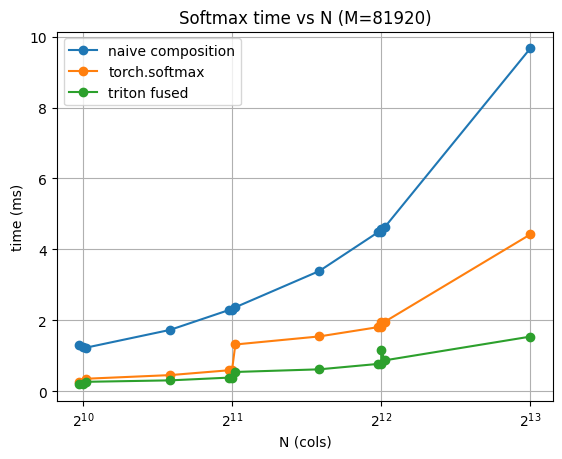

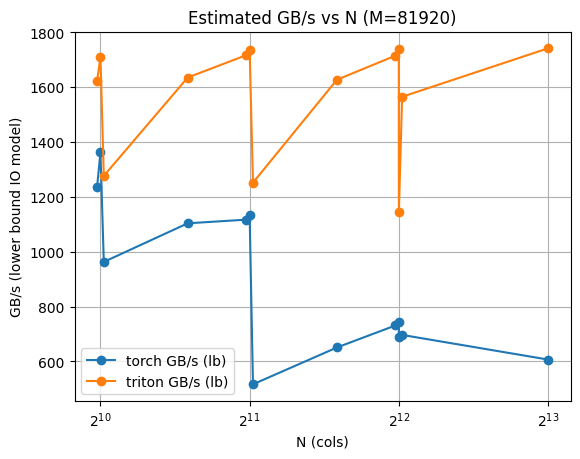

In [17]:
# A) Fix M big, sweep N to see BLOCK_SIZE jumps
resA = sweep_softmax(Ms=[81920], Ns=Ns_boundary, iters_naive=60, iters_fused=200, warmup=25, correctness_every=6)
plot_time_vs_N(resA, fixed_M=81920)
#plot_speedups_vs_N(resA, fixed_M=81920)
plot_bandwidth_vs_N(resA, fixed_M=81920)

M=    256 N= 1024 | BS= 1024 nw= 4 | naive   0.057 ms | torch   0.010 ms | triton   0.033 ms | triton/torch  0.29x
M=    512 N= 1024 | BS= 1024 nw= 4 | naive   0.056 ms | torch   0.010 ms | triton   0.031 ms | triton/torch  0.31x
M=   1024 N= 1024 | BS= 1024 nw= 4 | naive   0.057 ms | torch   0.011 ms | triton   0.032 ms | triton/torch  0.34x
M=   2048 N= 1024 | BS= 1024 nw= 4 | naive   0.056 ms | torch   0.013 ms | triton   0.032 ms | triton/torch  0.40x
M=   4096 N= 1024 | BS= 1024 nw= 4 | naive   0.084 ms | torch   0.019 ms | triton   0.031 ms | triton/torch  0.62x
M=   8192 N= 1024 | BS= 1024 nw= 4 | naive   0.152 ms | torch   0.039 ms | triton   0.031 ms | triton/torch  1.25x
M=  16384 N= 1024 | BS= 1024 nw= 4 | naive   0.300 ms | torch   0.066 ms | triton   0.046 ms | triton/torch  1.44x
M=  32768 N= 1024 | BS= 1024 nw= 4 | naive   0.555 ms | torch   0.116 ms | triton   0.085 ms | triton/torch  1.37x
M=  65536 N= 1024 | BS= 1024 nw= 4 | naive   0.958 ms | torch   0.199 ms | trito

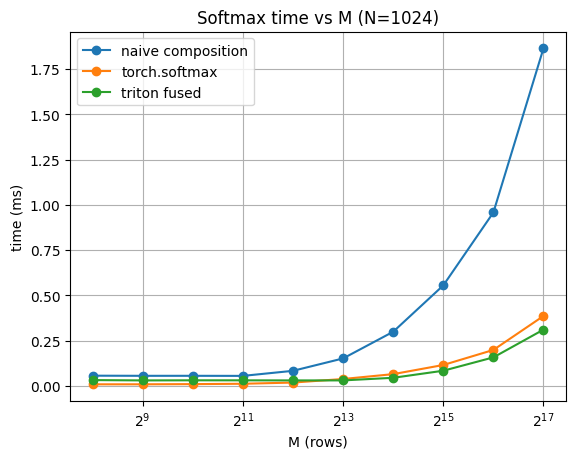

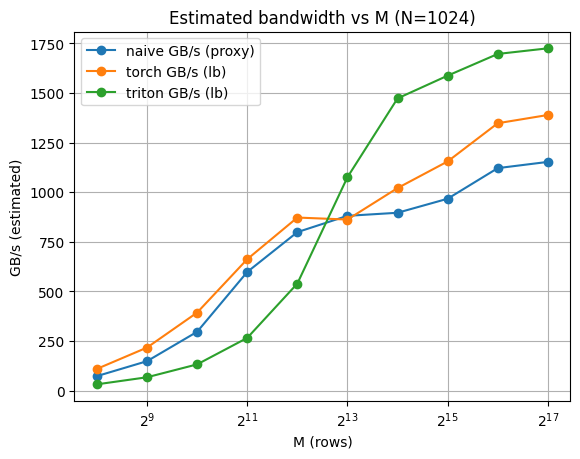

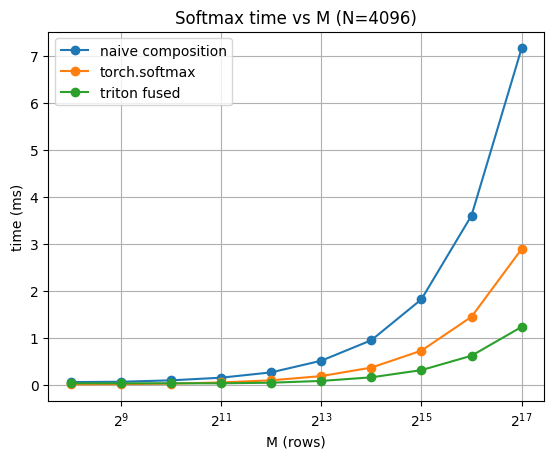

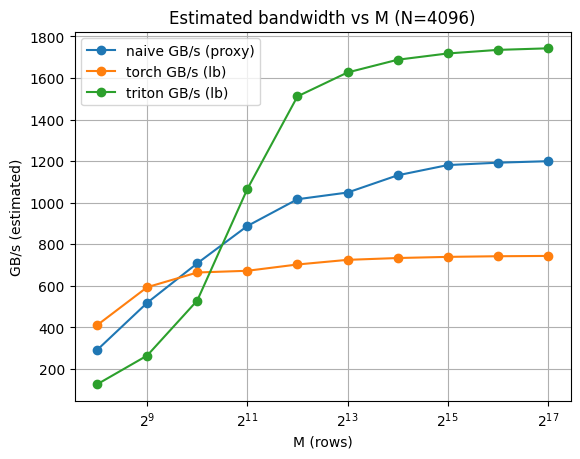

In [18]:
# B) Fix N, sweep M to see saturation
resB = sweep_softmax(Ms=Ms_sat, Ns=[1024, 4096], iters_naive=60, iters_fused=200, warmup=25)
plot_time_vs_M(resB, fixed_N=1024)
plot_bandwidth_vs_M(resB, fixed_N=1024)
plot_time_vs_M(resB, fixed_N=4096)
plot_bandwidth_vs_M(resB, fixed_N=4096)

M= 333056 N= 1008 | BS= 1024 nw= 4 | naive   4.628 ms | torch   0.974 ms | triton   0.781 ms | triton/torch  1.25x
M= 327680 N= 1024 | BS= 1024 nw= 4 | naive   4.583 ms | torch   0.953 ms | triton   0.766 ms | triton/torch  1.24x
M= 322816 N= 1040 | BS= 2048 nw= 8 | naive   4.667 ms | torch   1.367 ms | triton   1.042 ms | triton/torch  1.31x
M= 166656 N= 2016 | BS= 2048 nw= 8 | naive   4.612 ms | torch   1.183 ms | triton   0.778 ms | triton/torch  1.52x
M= 163840 N= 2048 | BS= 2048 nw= 8 | naive   4.529 ms | torch   1.163 ms | triton   0.767 ms | triton/torch  1.52x
M= 161536 N= 2080 | BS= 4096 nw=16 | naive   4.628 ms | torch   2.593 ms | triton   1.071 ms | triton/torch  2.42x
M=  83456 N= 4032 | BS= 4096 nw=16 | naive   4.566 ms | torch   1.841 ms | triton   0.786 ms | triton/torch  2.34x
M=  81920 N= 4096 | BS= 4096 nw=16 | naive   4.485 ms | torch   1.808 ms | triton   0.772 ms | triton/torch  2.34x
M=  80896 N= 4160 | BS= 8192 nw=16 | naive   4.565 ms | torch   1.933 ms | trito

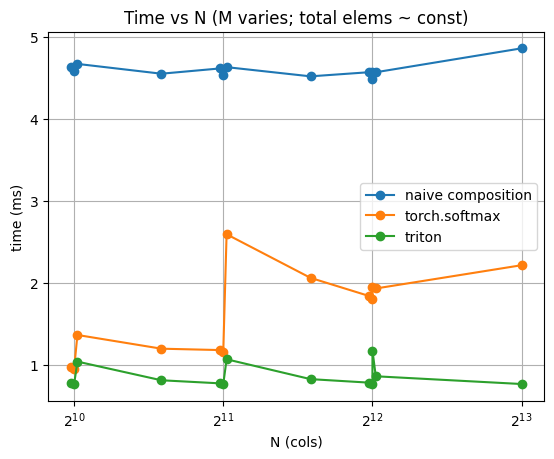

In [19]:
# C) Keep total work constant, sweep N (isolates shape effects)
TOTAL = 81920 * 4096
resC = sweep_softmax(Ms=[0], Ns=Ns_boundary, keep_total_elems=TOTAL, iters_naive=60, iters_fused=200, warmup=25)
plot_time_vs_N_variable_M(resC)